In [31]:
import kagglehub # might need to pip install kagglehub
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, max, min, countDistinct, sum, round
import geopandas as gpd
import plotly.express as px


# don't run this part still working on it

In [6]:
# Don't 

# Download the dataset to the current directory
try:
    # Replace with the correct dataset identifier
    path = kagglehub.dataset_download("erdi28/zip-codes-demographics")
    print(f"Dataset downloaded to: {path}")

    # Save the dataset as a CSV file in the current directory
    for file_name in os.listdir(path):
        if file_name.endswith(".csv"):
            shutil.move(os.path.join(path, file_name), os.getcwd())
            print(f"CSV file saved to: {os.path.join(os.getcwd(), file_name)}")
except AttributeError as e:
    print("Error: The kagglehub module does not support the method used.")
    print("Please check the documentation or update the library.")
except Exception as e:
    print(f"An error occurred: {e}")

100%|██████████| 2.28M/2.28M [00:00<00:00, 17.2MB/s]

Extracting files...
Dataset downloaded to: /Users/jim/.cache/kagglehub/datasets/erdi28/zip-codes-demographics/versions/3
CSV file saved to: /Users/jim/Projects/p1/ExploreZipCodeData_PySpark/zip_code_demographics.csv


In [29]:
## Set up PySpark environment
from pyspark.sql import SparkSession

In [30]:
## Initialize the SparkSession
# appName is the name of the application
# getOrCreate() creates a new session or retrieves an existing one
spark = SparkSession.builder \
    .appName("ZipCode PySpark Learning") \
        .getOrCreate()

## Verify that SparkSession is created
spark

In [4]:
try:
    zip_df = spark.read.csv ('./data/zip_code_demographics.csv', header=True, inferSchema=True)
    print('Data loaded successfully')
except Exception as e:
    print(f'Error loading data: {e}')

Data loaded successfully


In [32]:
zip_df.show(10)

+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
| zip|     lat|      lng|        city|state_id|   state_name|population|density|county_name|po_box|      dist_highway|dist2_large_airport|dist2_medium_airport|   dist_to_shore|number_of_business|adjusted_gross_income|total_income_amount|number_of_returns|
+----+--------+---------+------------+--------+-------------+----------+-------+-----------+------+------------------+-------------------+--------------------+----------------+------------------+---------------------+-------------------+-----------------+
|1001|42.06262|-72.62521|      Agawam|      MA|Massachusetts|     16088|  550.1|    Hampden|     0|  1.38703489958776|   106.145765467407|    12.9462123500772|93.0492507357679|               438|               598807|           6047

In [33]:
zip_df.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- state_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- density: double (nullable = true)
 |-- county_name: string (nullable = true)
 |-- po_box: integer (nullable = true)
 |-- dist_highway: double (nullable = true)
 |-- dist2_large_airport: double (nullable = true)
 |-- dist2_medium_airport: double (nullable = true)
 |-- dist_to_shore: double (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)
 |-- number_of_returns: integer (nullable = true)



## Pop by State -> in state pop by zip

In [34]:
zip_pop_df = zip_df.select('state_id','state_name','population').groupBy('state_id','state_name').agg(sum('population').alias("total_population"))
zip_pop_df.show(10)

+--------+--------------------+----------------+
|state_id|          state_name|total_population|
+--------+--------------------+----------------+
|      MT|             Montana|         1511394|
|      NC|      North Carolina|        12419438|
|      MD|            Maryland|         7224056|
|      CO|            Colorado|         6617159|
|      CT|         Connecticut|         3819343|
|      IL|            Illinois|        13819331|
|      WY|             Wyoming|         1182453|
|      NJ|          New Jersey|         9823423|
|      DE|            Delaware|         1372445|
|      DC|District of Columbia|         1207283|
+--------+--------------------+----------------+
only showing top 10 rows



In [35]:
zip_pop_df.orderBy(col("total_population").desc()).show(5)

+--------+------------+----------------+
|state_id|  state_name|total_population|
+--------+------------+----------------+
|      CA|  California|        44183935|
|      TX|       Texas|        33411444|
|      NY|    New York|        23903874|
|      FL|     Florida|        23007226|
|      PA|Pennsylvania|        16557706|
+--------+------------+----------------+
only showing top 5 rows



In [14]:
zip_pop_pd = zip_pop_df.toPandas()

In [15]:
shape_path = './data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
shape = gpd.read_file(shape_path)
print(shape.columns)

Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


In [16]:
shape_for_graph = pd.merge(
    left = shape,
    right = zip_pop_pd,
    left_on = 'NAME',
    right_on ='state_name',
    how = 'left'
)

In [17]:
shape_for_graph = shape_for_graph.dropna()


In [18]:
shape_for_graph = shape_for_graph[~shape_for_graph['NAME'].isin(['Alaska', 'Hawaii','Puerto Rico'])]

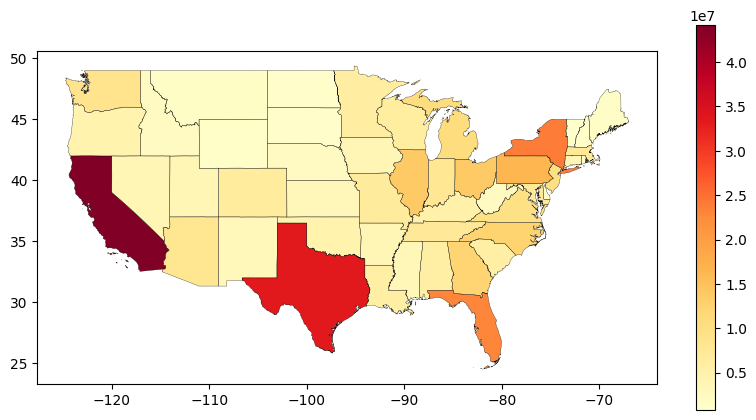

In [19]:
ax = shape_for_graph.boundary.plot(edgecolor ='black', linewidth=0.2, figsize=(10,5))
shape_for_graph.plot(ax=ax, column="total_population", legend=True, cmap='YlOrRd')
plt.show()

## Population by Zip Code of most Populated State, California\

In [36]:
# Collecting data for California
ca_zip_df = zip_df.select('zip','state_id', 'state_name', 'population') \
    .where(zip_df.state_id == 'CA') \
        .orderBy(col('population').desc())

ca_zip_df.show(10)

+-----+--------+----------+----------+
|  zip|state_id|state_name|population|
+-----+--------+----------+----------+
|90011|      CA|California|    109511|
|90650|      CA|California|    103427|
|91331|      CA|California|    102553|
|94565|      CA|California|    100700|
|90044|      CA|California|    100225|
|92336|      CA|California|     98896|
|92335|      CA|California|     97358|
|90805|      CA|California|     96840|
|90250|      CA|California|     96730|
|90201|      CA|California|     96605|
+-----+--------+----------+----------+
only showing top 10 rows



Exploring the data

In [37]:
# using pandas to check the shape of the dataframe
# this is a workaround to check the shape of the dataframe
ca_zip_df.toPandas().shape

(1802, 4)

In [38]:
# wanted to check if I had any duplicates or need to aggregate zip codes
ca_zip_df.toPandas().nunique()

zip           1802
state_id         1
state_name       1
population    1447
dtype: int64

In [39]:
ca_zip_df_shorted = ca_zip_df.orderBy(col('population').desc())
# Select the top 2 rows
top_2 = ca_zip_df_shorted.limit(5)

# Select the bottom 2 rows
# where the population is greater than 0 to avoid empty rows
bottom_2 = ca_zip_df_shorted.where(col('population') > 0).orderBy(col('population').asc()).limit(5)

# Calculate the middle row index
total_rows = ca_zip_df_shorted.count()
middle_index = total_rows // 2

# Select the middle row(s)
# had to convert to pandas to use tail to get that last row
# because pyspark doesn't have a direct way to get the middle row
middle_rows = ca_zip_df_shorted.orderBy(col('population').desc()).limit(middle_index + 1).toPandas().tail(1)


ca_new = pd.concat([top_2.toPandas(), middle_rows, bottom_2.toPandas()], ignore_index=True)

ca_new

zip state_id  state_name  population
0   90011       CA  California      109511
1   90650       CA  California      103427
2   91331       CA  California      102553
3   94565       CA  California      100700
4   90044       CA  California      100225
5   94519       CA  California       20495
6   93621       CA  California          31
7   96071       CA  California          86
8   96040       CA  California          86
9   95375       CA  California          97
10  95335       CA  California          97

Make Pie Chart to look at population distribution

In [41]:
over_100k = ca_zip_df.filter(col('population') > 100000).count()
between_80k_100k = ca_zip_df.filter(col('population').between(80000, 100000)).count() # inclusive
between_50k_80k =  ca_zip_df.filter((col('population') > 50000) & (col('population') < 80000)).count()
between_20k_50k =  ca_zip_df.filter((col('population') > 20000) & (col('population') <= 50000)).count()
less_20k =  ca_zip_df.filter(col('population') <= 20000).count()
# Create a list of the counts
counts = [over_100k, between_80k_100k, between_50k_80k, between_20k_50k, less_20k]
# Create a list of the labels
labels = ['Over 100k', '80k-100k', '50k-80k', '20k-50k', 'Less than 20k']
# create a dataframe to plot
counts_df = pd.DataFrame({'Population Range': labels, 'Count': counts})

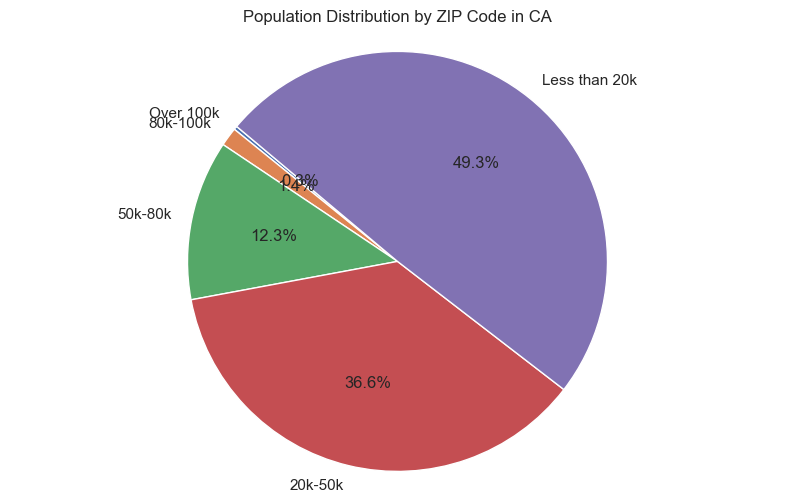

In [42]:
# Plotting the data using seaborn pie chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
# Create a pie chart
plt.pie(counts_df['Count'], labels=counts_df['Population Range'], autopct='%1.1f%%', startangle=140)
plt.title('Population Distribution by ZIP Code in CA')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## AGI by buisness by zip

Make a dataset of only values pertaining to desired calculations.

In [20]:
df_limited= zip_df[['zip', 'city', 'state_id', 'number_of_business', 'adjusted_gross_income', 'total_income_amount']]

In [21]:
df_limited.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)



In [22]:
numeric_cols = [c for c, t in df_limited.dtypes if t.startswith('string')==False]
df_limited.select(*numeric_cols).summary().show()

25/04/18 15:49:22 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+---------------------+-------------------+
|summary|              zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+-----------------+------------------+---------------------+-------------------+
|  count|            33704|             33624|                33704|              33704|
|   mean|49842.60782103014| 260.6949202950274|   425134.10239140753| 429894.33857557003|
| stddev|27451.11144214845|432.11281369671184|    756151.9395034771|  764441.5938419583|
|    min|             1001|                 1|                  577|              577.0|
|    25%|            27051|                19|                32471|         32873.0001|
|    50%|            49776|                74|               112840|           114006.0|
|    75%|            72206|               333|               505154|           509227.0|
|    max|            99929|              7263|             15224673|        1.5277982E7|
+-------+------------

Reviewing of data showed instances of number of businesses being null.

In [23]:
print(33704-33624)
df_limited.filter(col('number_of_business').isNull()).show()

80
+-----+--------------+--------+------------------+---------------------+-------------------+
|  zip|          city|state_id|number_of_business|adjusted_gross_income|total_income_amount|
+-----+--------------+--------+------------------+---------------------+-------------------+
|12115| Malden Bridge|      NY|              NULL|                19103|         19154.0002|
|14819|       Cameron|      NY|              NULL|                12293|         12320.0002|
|15429|         Denbo|      PA|              NULL|                 4667|             4667.0|
|16691| Wells Tannery|      PA|              NULL|                 8832|          8858.0004|
|20606|         Abell|      MD|              NULL|                12492|         12533.0002|
|22504|      Laneview|      VA|              NULL|                 6260|          6292.0003|
|23068|    Hallieford|      VA|              NULL|                 8923|          8956.0002|
|23488|       Withams|      VA|              NULL|                 

For the purposes of AGI in relation to number of businesses generated a dataset dropping instances of no businesses being recorded.

In [24]:
df_AGI_v_Business = df_limited.na.drop(subset=['number_of_business'])

In [25]:
numeric_cols = [c for c, t in df_AGI_v_Business.dtypes if t.startswith('string')==False]
df_AGI_v_Business.select(*numeric_cols).summary().show()

+-------+------------------+------------------+---------------------+-------------------+
|summary|               zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+------------------+------------------+---------------------+-------------------+
|  count|             33624|             33624|                33624|              33624|
|   mean|49841.581251487034| 260.6949202950274|     426128.850672139|  430900.3270977903|
| stddev|27464.851381954184|432.11281369671184|    756775.5571880672|  765071.8628725683|
|    min|              1001|                 1|                  577|              577.0|
|    25%|             27046|                19|                32769|            33180.0|
|    50%|             49781|                74|               113622|           115128.0|
|    75%|             72223|               333|               505229|           510234.0|
|    max|             99929|              7263|             15224673|        1.5277982E7|
+-------+-

Generate new column to show AGI per Business.

In [26]:
df_AGI_v_Business = df_AGI_v_Business.select("*", (col("adjusted_gross_income") / col("number_of_business")).alias("AGI per Business"))

In [27]:
df_AGI_v_Business.printSchema()

root
 |-- zip: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state_id: string (nullable = true)
 |-- number_of_business: integer (nullable = true)
 |-- adjusted_gross_income: integer (nullable = true)
 |-- total_income_amount: double (nullable = true)
 |-- AGI per Business: double (nullable = true)



In [28]:
numeric_cols = [c for c, t in df_AGI_v_Business.dtypes if t.startswith('string')==False]
df_AGI_v_Business.select(*numeric_cols).summary().show()

+-------+------------------+------------------+---------------------+-------------------+------------------+
|summary|               zip|number_of_business|adjusted_gross_income|total_income_amount|  AGI per Business|
+-------+------------------+------------------+---------------------+-------------------+------------------+
|  count|             33624|             33624|                33624|              33624|             33624|
|   mean|49841.581251487034| 260.6949202950274|     426128.850672139|  430900.3270977903|2020.7699515399624|
| stddev|27464.851381954184|432.11281369671184|    756775.5571880672|  765071.8628725683|1680.3575191855648|
|    min|              1001|                 1|                  577|              577.0|12.113924050632912|
|    25%|             27046|                19|                32769|            33180.0| 1086.376811594203|
|    50%|             49781|                74|               113622|           115128.0|1639.2309941520468|
|    75%|          

In order to plot needed to convert to pandas.

In [29]:
pandas_df = df_AGI_v_Business.toPandas()

In [30]:
pandas_df['AGI per Business'].describe()

count    33624.000000
mean      2020.769952
std       1680.357519
min         12.113924
25%       1086.376812
50%       1639.273140
75%       2450.263251
max      84963.500000
Name: AGI per Business, dtype: float64

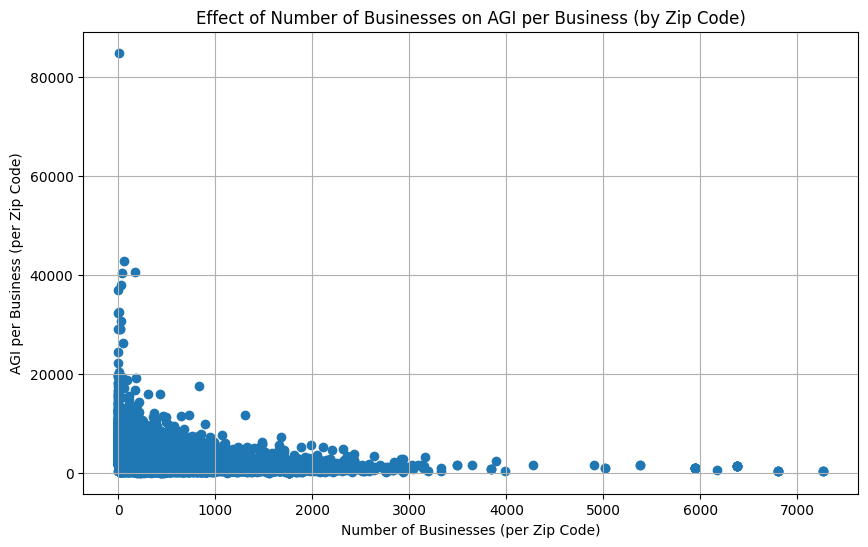

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['number_of_business'], pandas_df['AGI per Business'])
plt.xlabel("Number of Businesses (per Zip Code)")
plt.ylabel("AGI per Business (per Zip Code)")
plt.title("Effect of Number of Businesses on AGI per Business (by Zip Code)")
plt.grid(True)
plt.show()

Decided to generate a plot graph that could be hovered over to investigate results.

In [32]:
fig = px.scatter(pandas_df,
                 x='number_of_business',
                 y='AGI per Business',
                 hover_data=['number_of_business', 'AGI per Business', 'zip'], # Add other columns to display on hover
                 labels={'number_of_business': 'Number of Businesses (per Zip Code)',
                         'AGI per Business': 'AGI per Business (per Zip Code)'},
                 title='Effect of Number of Businesses on AGI per Business (by Zip Code)')
fig.show()

The values shown for number of businesses when looking into outlying instances zip code 80297 (Colorado Springs, Colorado) having 4 businesses and 10199 (New York, New York) having 7263 businesses led me to want to delve deeper into those locations as the data seemed off. I decided to review the sources used in the creation of this dataset at https://github.com/erkara/auc-data-challenge-23/blob/main/data_sources.xlsx. There it indicated the values are pulled from realdatasets.com for the year of 2012. US Census Bureau states 12 establishments for 10199 in 2012 (https://data.census.gov/profile?q=2012+zip+code+business&g=010XX00US$8600000_860XX00US10199&y=2012). While 80297 does not appear in the 2012 census data.      

## AGI by total income by zip 

In [33]:
numeric_cols = [c for c, t in df_limited.dtypes if t.startswith('string')==False]
df_limited.select(*numeric_cols).summary().show()

+-------+-----------------+------------------+---------------------+-------------------+
|summary|              zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+-----------------+------------------+---------------------+-------------------+
|  count|            33704|             33624|                33704|              33704|
|   mean|49842.60782103014| 260.6949202950274|   425134.10239140753| 429894.33857557003|
| stddev|27451.11144214845|432.11281369671184|    756151.9395034771|  764441.5938419583|
|    min|             1001|                 1|                  577|              577.0|
|    25%|            27051|                19|                32471|         32873.0001|
|    50%|            49776|                74|               112840|           114006.0|
|    75%|            72206|               333|               505154|           509227.0|
|    max|            99929|              7263|             15224673|        1.5277982E7|
+-------+------------

Create a new dataset where the AGI is below the mean and the total income is above the mean.

In [34]:
filtered_df = df_limited.filter(col("adjusted_gross_income") < 425134.10239140753)
filtered_df = filtered_df.filter(col("total_income_amount") > 429894.33857557003)

In [35]:
numeric_cols = [c for c, t in filtered_df.dtypes if t.startswith('string')==False]
filtered_df.select(*numeric_cols).summary().show()

+-------+-----------------+------------------+---------------------+-------------------+
|summary|              zip|number_of_business|adjusted_gross_income|total_income_amount|
+-------+-----------------+------------------+---------------------+-------------------+
|  count|               11|                11|                   11|                 11|
|   mean|61758.72727272727|505.27272727272725|   424454.36363636365|  431883.8181818182|
| stddev|35880.84149261528|  295.339157887704|   355.43699096387456| 1227.7339140206066|
|    min|             4046|               192|               423630|           430086.0|
|    25%|            19031|               328|               424278|           430561.0|
|    50%|            79360|               499|               424488|           431912.0|
|    75%|            90013|               521|               424805|           432930.0|
|    max|            99663|              1317|               424876|           433893.0|
+-------+------------

In [36]:
filtered_df.show()

+-----+--------------+--------+------------------+---------------------+-------------------+
|  zip|          city|state_id|number_of_business|adjusted_gross_income|total_income_amount|
+-----+--------------+--------+------------------+---------------------+-------------------+
| 4046| Kennebunkport|      ME|               328|               424805|           433893.0|
| 7727|   Farmingdale|      NJ|               401|               423630|           430561.0|
|19031|     Flourtown|      PA|               192|               424876|           431616.0|
|53959|     Reedsburg|      WI|               328|               424844|           430086.0|
|63501|    Kirksville|      MO|               616|               424355|           431049.0|
|79360|      Seminole|      TX|               336|               424311|           431912.0|
|81201|        Salida|      CO|               499|               424488|           432930.0|
|90013|   Los Angeles|      CA|              1317|               42464

The above table shows the results but variation between the zipcodes is minimal when the application of removing above mean AGI and below mean total income leading to no value to visual plot. 

## AGI by Population

In [37]:
df_limited_AGI_Pop= zip_df[['zip', 'city', 'state_id', 'population', 'adjusted_gross_income']]

In [38]:
numeric_cols = [c for c, t in df_limited_AGI_Pop.dtypes if t.startswith('string')==False]
df_limited_AGI_Pop.select(*numeric_cols).summary().show()

+-------+-----------------+------------------+---------------------+
|summary|              zip|        population|adjusted_gross_income|
+-------+-----------------+------------------+---------------------+
|  count|            33704|             33704|                33704|
|   mean|49842.60782103014|11287.959737716592|   425134.10239140753|
| stddev|27451.11144214845|15200.216997387142|    756151.9395034771|
|    min|             1001|                 0|                  577|
|    25%|            27051|              1253|                32471|
|    50%|            49776|              4099|               112840|
|    75%|            72206|             16104|               505154|
|    max|            99929|            130352|             15224673|
+-------+-----------------+------------------+---------------------+



In [39]:
df_limited_AGI_Pop_sorted = df_limited_AGI_Pop.sort('population')

In [40]:
pandas_AGI_Pop_df = df_limited_AGI_Pop_sorted.toPandas()

In [41]:
fig = px.scatter(pandas_AGI_Pop_df,
                 x='population',
                 y='adjusted_gross_income',
                 hover_data=['population', 'adjusted_gross_income', 'zip'], # Add other columns to display on hover
                 labels={'population': 'Population (per Zip Code)',
                         'adjusted_gross_income': 'AGI per (per Zip Code)'},
                 title='Effect of Population on Adjusted Gross Income (by Zip Code)')
fig.show()

The scatter plot above shows that the AGI for a zip code does increase with population yet not a 1 to 1 result. There are too many outliers that show a much greater AGI indepentant of population.

## Top 10 Cities Closest to the Shore Ranked By # of Business

In [8]:
#Creating a new DataFrame with the needed columns
sho_df = zip_df[['state_id', 'city', 'number_of_business', 'dist_to_shore']]
sho_df.show()

+--------+---------------+------------------+----------------+
|state_id|           city|number_of_business|   dist_to_shore|
+--------+---------------+------------------+----------------+
|      MA|         Agawam|               438|93.0492507357679|
|      MA|        Amherst|               571|133.370143966814|
|      MA|          Barre|                97|97.6398810953817|
|      MA|    Belchertown|               217|114.406033754504|
|      MA|      Blandford|                18|107.466779445914|
|      MA|      Brimfield|                73|94.9280235181023|
|      MA|        Chester|                13|128.563170400209|
|      MA|   Chesterfield|                10|137.693284947624|
|      MA|       Chicopee|               317|104.576258028243|
|      MA|       Chicopee|               550|105.789420653597|
|      MA|       Chicopee|                63|107.544849378402|
|      MA|     Cummington|                18|147.638866780228|
|      MA|    Easthampton|               372| 124.36751

In [9]:
#Rounding dist_to_shore to 2 decimal places
sho_df = sho_df.withColumn('dist_to_shore', round('dist_to_shore', 2))
sho_df.show(10)

+--------+------------+------------------+-------------+
|state_id|        city|number_of_business|dist_to_shore|
+--------+------------+------------------+-------------+
|      MA|      Agawam|               438|        93.05|
|      MA|     Amherst|               571|       133.37|
|      MA|       Barre|                97|        97.64|
|      MA| Belchertown|               217|       114.41|
|      MA|   Blandford|                18|       107.47|
|      MA|   Brimfield|                73|        94.93|
|      MA|     Chester|                13|       128.56|
|      MA|Chesterfield|                10|       137.69|
|      MA|    Chicopee|               317|       104.58|
|      MA|    Chicopee|               550|       105.79|
+--------+------------+------------------+-------------+
only showing top 10 rows



In [10]:
#dropping duplicates and sort by distance to shore
unique_sho_df = sho_df.dropDuplicates()
print((unique_sho_df.count(), len(unique_sho_df.columns)))

(33671, 4)


In [11]:
#sort dataset closest to farthest to shore
sorted_sho_df = unique_sho_df.sort(col('dist_to_shore').asc())
top_10_cities = sorted_sho_df.limit(10)
top_10_cities.show()

+--------+----------+------------------+-------------+
|state_id|      city|number_of_business|dist_to_shore|
+--------+----------+------------------+-------------+
|      MI| Luna Pier|                12|         0.01|
|      FL|   Captiva|                89|         0.01|
|      WA|Bellingham|              1993|         0.02|
|      ME| Matinicus|                69|         0.02|
|      AK|Petersburg|               147|         0.02|
|      FL|  Key West|              1546|         0.07|
|      MD|     Issue|                 8|         0.09|
|      ME|    Sunset|                 7|          0.1|
|      NC|  Ocracoke|                18|          0.1|
|      NJ| Highlands|                86|         0.14|
+--------+----------+------------------+-------------+



In [12]:
#plotting the dataframe
top_10_cities_df = top_10_cities.toPandas()
top_10_cities_df.head()

state_id        city  number_of_business  dist_to_shore
0       MI   Luna Pier                  12           0.01
1       FL     Captiva                  89           0.01
2       WA  Bellingham                1993           0.02
3       ME   Matinicus                  69           0.02
4       AK  Petersburg                 147           0.02

In [13]:
# Combining columns after ensuring compatibility
top_10_cities_df['city'] = top_10_cities_df['city'] + ', ' + top_10_cities_df['state_id']
top_10_cities_df.head()

state_id            city  number_of_business  dist_to_shore
0       MI   Luna Pier, MI                  12           0.01
1       FL     Captiva, FL                  89           0.01
2       WA  Bellingham, WA                1993           0.02
3       ME   Matinicus, ME                  69           0.02
4       AK  Petersburg, AK                 147           0.02

In [14]:
#drop state column
top_10_cities_df = top_10_cities_df.drop('state_id', axis=1)
top_10_cities_df

city  number_of_business  dist_to_shore
0   Luna Pier, MI                  12           0.01
1     Captiva, FL                  89           0.01
2  Bellingham, WA                1993           0.02
3   Matinicus, ME                  69           0.02
4  Petersburg, AK                 147           0.02
5    Key West, FL                1546           0.07
6       Issue, MD                   8           0.09
7      Sunset, ME                   7           0.10
8    Ocracoke, NC                  18           0.10
9   Highlands, NJ                  86           0.14

In [15]:
ranked_by_biz = top_10_cities_df.sort_values(by='number_of_business', ascending=False)
ranked_by_biz

city  number_of_business  dist_to_shore
2  Bellingham, WA                1993           0.02
5    Key West, FL                1546           0.07
4  Petersburg, AK                 147           0.02
1     Captiva, FL                  89           0.01
9   Highlands, NJ                  86           0.14
3   Matinicus, ME                  69           0.02
8    Ocracoke, NC                  18           0.10
0   Luna Pier, MI                  12           0.01
6       Issue, MD                   8           0.09
7      Sunset, ME                   7           0.10

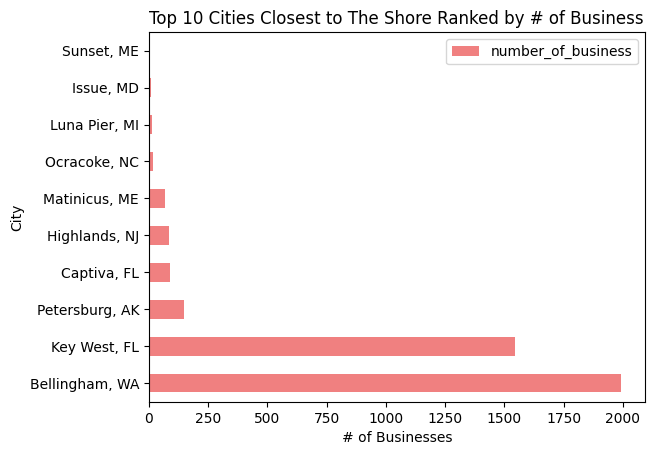

In [16]:
#plotting the dataframe
ranked_by_biz.plot.barh(x='city', y='number_of_business', color='lightcoral')
plt.xlabel('# of Businesses')
plt.ylabel('City')
plt.title('Top 10 Cities Closest to The Shore Ranked by # of Business')
plt.show()

### Number of Businesses vs Distance to Shore

In [17]:
#number of biz and distance to shore dataframe
biz_shore_df = zip_df[['number_of_business', 'dist_to_shore']]
biz_shore_df.show()

+------------------+----------------+
|number_of_business|   dist_to_shore|
+------------------+----------------+
|               438|93.0492507357679|
|               571|133.370143966814|
|                97|97.6398810953817|
|               217|114.406033754504|
|                18|107.466779445914|
|                73|94.9280235181023|
|                13|128.563170400209|
|                10|137.693284947624|
|               317|104.576258028243|
|               550|105.789420653597|
|                63|107.544849378402|
|                18|147.638866780228|
|               372| 124.36751323717|
|               503|90.9561490159946|
|               201|93.9142965327369|
|                20|105.585525845634|
|                19|144.073456496879|
|               131|113.854927890354|
|                28|  95.75593334735|
|               309|125.712746119424|
+------------------+----------------+
only showing top 20 rows



In [18]:
#cleaning it up a bit
biz_shore_df = biz_shore_df.withColumn('dist_to_shore', round('dist_to_shore', 2))
biz_shore_df.show(5)

+------------------+-------------+
|number_of_business|dist_to_shore|
+------------------+-------------+
|               438|        93.05|
|               571|       133.37|
|                97|        97.64|
|               217|       114.41|
|                18|       107.47|
+------------------+-------------+
only showing top 5 rows



In [19]:
%matplotlib inline
#change to Pandas df
biz_shore_panda = biz_shore_df.toPandas()

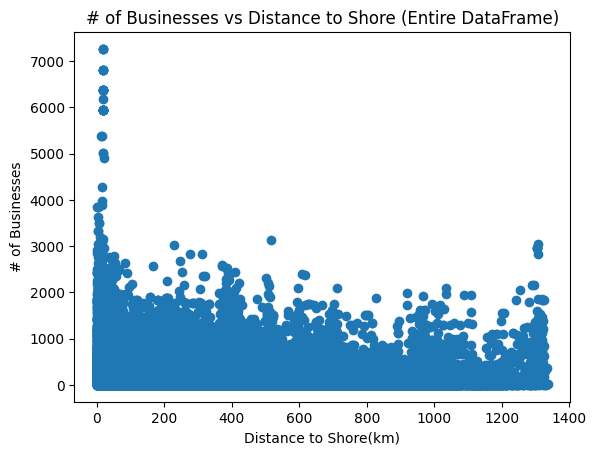

In [20]:
plt.scatter(biz_shore_panda['dist_to_shore'], biz_shore_panda['number_of_business'])
plt.title("# of Businesses vs Distance to Shore (Entire DataFrame)")
plt.xlabel("Distance to Shore(km)")
plt.ylabel("# of Businesses")
plt.show()

* Amount of businesses near the shore begin to taper off near 2000.
* Farther away from the shore, slightly less # of businesses
* Several outliers with high # of businesses near the shore

## Number of Tax Returns by County

In [34]:
returns_by_county = zip_df[['number_of_returns','county_name']]
returns_by_county.show()

+-----------------+-----------+
|number_of_returns|county_name|
+-----------------+-----------+
|             9320|    Hampden|
|             9880|  Hampshire|
|             2490|  Worcester|
|             7970|  Hampshire|
|              660|    Hampden|
|             1980|    Hampden|
|              630|    Hampden|
|              410|  Hampshire|
|            11270|    Hampden|
|            15760|    Hampden|
|             1180|    Hampden|
|              520|  Hampshire|
|            10070|  Hampshire|
|             8540|    Hampden|
|             6170|    Hampden|
|              570|  Worcester|
|              270|  Hampshire|
|             3370|  Hampshire|
|             1040|    Hampden|
|             2920|  Hampshire|
+-----------------+-----------+
only showing top 20 rows



In [35]:
plot_returns = returns_by_county.groupBy('county_name').sum('number_of_returns') 
plot_returns.show()

+--------------+----------------------+
|   county_name|sum(number_of_returns)|
+--------------+----------------------+
|     Worcester|                476700|
|         Bucks|                384940|
|       Hanover|                 72920|
|         Tyler|                 14530|
|        Aitkin|                  9300|
|     Petroleum|                   180|
|      Thurston|                170330|
|East Feliciana|                  8950|
|        Grimes|                 15660|
|          Utah|                301400|
|    Charleston|                251190|
|         Pasco|                274050|
|     Oktibbeha|                 34110|
|      Montcalm|                 32250|
|    Deer Lodge|                  8900|
|       Shannon|                  3400|
|         Izard|                  5740|
|      Angelina|                 51190|
|        Cayuga|                 56630|
|      McDowell|                 40840|
+--------------+----------------------+
only showing top 20 rows



In [36]:
plot_returns.summary().show()

+-------+-----------+----------------------+
|summary|county_name|sum(number_of_returns)|
+-------+-----------+----------------------+
|  count|       1800|                  1800|
|   mean|       NULL|    100023.61666666667|
| stddev|       NULL|    258816.38111612992|
|    min|  Abbeville|                   130|
|    25%|       NULL|                  7720|
|    50%|       NULL|                 23120|
|    75%|       NULL|                 79920|
|    max|    Ziebach|               5111780|
+-------+-----------+----------------------+



In [37]:
df_plot = plot_returns.toPandas()

In [38]:
fig = px.scatter(df_plot,
                 x='sum(number_of_returns)',
                 y='county_name',
                 title='Tax Returns By County')
fig

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'sum(number_of_returns)=%{x}<br>county_name=%{y}<extra></extra>',
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': {'bdata': ('HEYHAKzfBQDYHAEAwjgAAFQkAAC0AA' ... 'cAABCLAAAgigAApr0AAHJ0AADcNwAA'),
                    'dtype': 'i4'},
              'xaxis': 'x',
              'y': array(['Worcester', 'Bucks', 'Hanover', ..., 'Fairbanks North Star',
                          'Walla Walla', 'Klickitat'], shape=(1800,), dtype=object),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Tax Returns By County'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'sum(number_of_returns)'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'county_name'}}}
})

## Distance highway/airport Pop by zipcode

In [39]:
highway_airport = zip_df[['dist_highway','dist2_large_airport','dist2_medium_airport','population','zip']]

In [40]:
highway_airport.show()

+------------------+-------------------+--------------------+----------+----+
|      dist_highway|dist2_large_airport|dist2_medium_airport|population| zip|
+------------------+-------------------+--------------------+----------+----+
|  1.38703489958776|   106.145765467407|    12.9462123500772|     16088|1001|
|  14.4381771787811|   112.264368137872|    21.0800788136799|     27323|1002|
|  16.7883389378764|    90.664964214599|    25.5477180736873|      4947|1005|
|   13.663839468365|   101.552921217705|     14.762395370048|     15304|1007|
|  2.59365546872497|    136.54879743219|    20.1779499690055|      1171|1008|
|  4.73727136188264|   78.6454995903817|    28.0492624787917|      3703|1010|
|  8.05869305726245|   142.414627001912|    26.0419084149722|      1332|1011|
|  18.3310957824545|   138.381683922713|    27.4666636064825|       503|1012|
|0.0622862708325111|   109.114246004907|    7.07589281728133|     22709|1013|
| 0.925139778004274|   106.769094716986|    3.20553313229515|   

In [41]:
highway_airport_2 = highway_airport.select('zip','population',round('dist_highway', 2).alias('highway_dist'),round('dist2_large_airport', 2).alias('dist_large_airport'),round('dist2_medium_airport', 2).alias('dist_medium_airport'))

In [42]:
highway_airport_2.dtypes

[('zip', 'int'),
 ('population', 'int'),
 ('highway_dist', 'double'),
 ('dist_large_airport', 'double'),
 ('dist_medium_airport', 'double')]

In [45]:
from pyspark.sql.types import StringType

highway_airport_2 = highway_airport_2.withColumn('zips', highway_airport_2['zip'].cast(StringType()))

In [46]:
highway_airport_2.show()

+----+----------+------------+------------------+-------------------+----+
| zip|population|highway_dist|dist_large_airport|dist_medium_airport|zips|
+----+----------+------------+------------------+-------------------+----+
|1001|     16088|        1.39|            106.15|              12.95|1001|
|1002|     27323|       14.44|            112.26|              21.08|1002|
|1005|      4947|       16.79|             90.66|              25.55|1005|
|1007|     15304|       13.66|            101.55|              14.76|1007|
|1008|      1171|        2.59|            136.55|              20.18|1008|
|1010|      3703|        4.74|             78.65|              28.05|1010|
|1011|      1332|        8.06|            142.41|              26.04|1011|
|1012|       503|       18.33|            138.38|              27.47|1012|
|1013|     22709|        0.06|            109.11|               7.08|1013|
|1020|     30704|        0.93|            106.77|               3.21|1020|
|1022|      2235|        

In [47]:
hw_air = highway_airport_2.toPandas()

In [49]:
fig = px.scatter(hw_air,
                 x='zips',
                 y='population',
                 hover_data=['highway_dist', 'dist_large_airport', 'dist_medium_airport'], # Add other columns to display on hover
                 
                 title='Population by zipcode with distance to Highway and Airports in miles')
fig


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': {'bdata': ('PQrXo3A99j+amZmZmYlaQGZmZmZm5i' ... '5H4XoU9j9mZmZmZgZHQPYoXI/C9RlA'),
                             'dtype': 'f8',
                             'shape': '33704, 3'},
              'hovertemplate': ('zips=%{x}<br>population=%{y}<b' ... '{customdata[2]}<extra></extra>'),
              'legendgroup': '',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'showlegend': False,
              'type': 'scattergl',
              'x': array(['1001', '1002', '1005', ..., '40027', '40292', '44316'],
                         shape=(33704,), dtype=object),
              'xaxis': 'x',
              'y': {'bdata': ('2D4AALtqAABTEwAAyDsAAJMEAAB3Dg' ... 'AANjsAAE4oAAB2VAAA/S4AALsGAAA='),
                    'dtype': 'i4'},
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'text': 'Population by zipcode with distance to Highway and Airports in miles'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'zips'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'population'}}}
})